## Random Model Editing: How does performance change when the model is randomly changed rather than using an image to guide the edit?

In [1]:
# General imports
# import torch
import numpy as np
import os, sys
import json
# from tqdm import tqdm
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Local imports
sys.path.insert(0, 'src')
from test import predict
from parse_config import ConfigParser
import datasets.datasets as module_data

import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from trainer.editor import Editor

from utils import read_json, read_lists, informal_log, list_to_dict, write_lists, write_json, ensure_files, ensure_dir
from utils.model_utils import prepare_device
from utils.results_to_csv import store_csv
from utils.edit_utils import prepare_edit_data #, get_target_weights
from utils.knn_utils import knn, analyze_knn, load_and_analyze_knn
from utils.df_utils import load_and_preprocess_csv, summary_histogram
from utils.visualizations import histogram

from edit_knn import main as edit

# fix random seeds for reproducibility
SEED = 123
# torch.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

### Outline

1. given a path of keys and values
2. perform an edit for each key and value
    a. save the weight difference in a list
3. after all edits, stack the tensors and take the mean and std

In [4]:
# Define constants, paths
class_list_path = os.path.join('metadata', 'cinic-10', 'class_names.txt')
# Define constants, paths
config_path = 'configs/copies/edit_experiments/cinic10_imagenet-random_edit.json'
class_list_path = 'metadata/cinic-10/class_names.txt'

analyze_in_edit = False
sort_type = 'softmax'

In [5]:
timestamp = datetime.now().strftime(r'%m%d_%H%M%S')
paths_timestamp = '0126_161209'


In [51]:
# # Load config file
# config_dict = read_json(config_path)
# Load class list and obtain target class idx
class_list = read_lists(class_list_path)
class_idx_dict = list_to_dict(class_list)

# n_select = 100

# # Set K
# K = config_dict['editor']['K']

# device, device_ids = prepare_device(config_dict['n_gpu'])
random_csv_path = 'saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0131_134915/results_table.csv'
edit_csv_path = 'saved/edit/trials/CINIC10_ImageNet-VGG_16/airplane_100/0127_103716/results_table.csv'
target_class_name = 'airplane'
target_class_idx = class_idx_dict[target_class_name]
save_visualizations_dir = os.path.join(os.path.dirname(random_csv_path), 'graphs')
ensure_dir(save_visualizations_dir)

In [52]:
histogram(
    data=data.detach().cpu().numpy(),
    n_bins=100,
    xlabel='Delta Weight',
    ylabel='counts')

NameError: name 'data' is not defined

### Analyze the results from random model editing

In [53]:
# Before calling this, call python src/utils/results_to_csv.py with the trial_paths_path

random_df = load_and_preprocess_csv(
    csv_path=random_csv_path,
    drop_duplicates=['ID'])
print("{} rows in data frame from random edits".format(len(random_df)))

edit_df = load_and_preprocess_csv(
    csv_path=edit_csv_path,
    drop_duplicates=['ID'])
print("{} rows in data frame from legit edits".format(len(edit_df)))

100 rows in data frame from random edits
158 rows in data frame from legit edits


In [54]:
def summary_histograms(dfs,
                       metrics=None,
                       n_bins=10,
                       save_dir=None,
                       labels=None,
                       tag=None):
    '''
    Display/save histograms of distributions of the metrics provided

    Arg(s):
        df : pd.DataFrame
            Data fram as result of results_to_csv.py
        metrics : list[list[str]]
            list of list of metrics with Pre/Post replaced by {}
        n_bins : int
            number of bins in histogram
        save_dir : str or None
            directory to save histogram to
        tag : str or None
            label in front of metric name when saving histogram.

    '''
    if labels is None:
        labels = [i for i in range(len(dfs))]
    if metrics is None:
        metrics = [['{} Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1'],
                   ['{} Target Precision', '{} Target Recall', '{} Target F1'],
                   ['{} Orig Pred Precision', '{} Orig Pred Recall', '{} Orig Pred F1']]

    mean_df = dfs[0].mean()
    for row in metrics:
        for metric in row:
            data = []
            for df in dfs:
                try:
                    pre_metric_mean = mean_df[metric.format("Pre")]
                    data.append(df[metric.format("Post")].to_numpy())
                except:
                    print("Unable to find metric '{}' in dataframe".format(metric))
                    continue
                # Create save directory
                if save_dir is not None:
                    if tag is None:
                        save_path = os.path.join(save_dir, metric.format("").strip())
                    else:
                        save_path = os.path.join(save_dir, tag + "_" + metric.format("").strip())
                else:
                    save_path = None

            histogram(
                # data=post_metric,
                data=data,
                n_bins=n_bins,
                marker=pre_metric_mean,
                title=metric.format("Post"),
                xlabel=metric.split(" ", maxsplit=1)[1],
                ylabel="Counts",
                labels=labels,
                save_path=save_path)

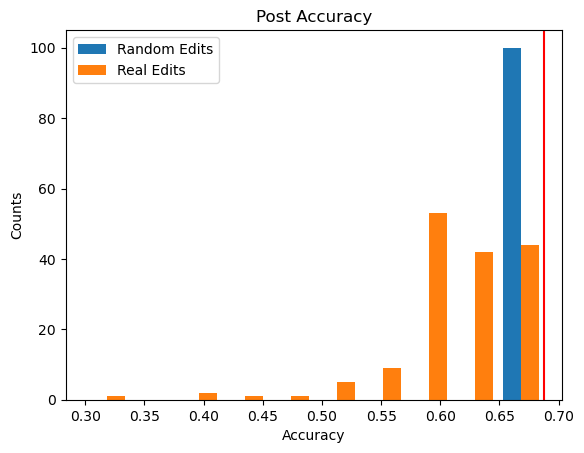

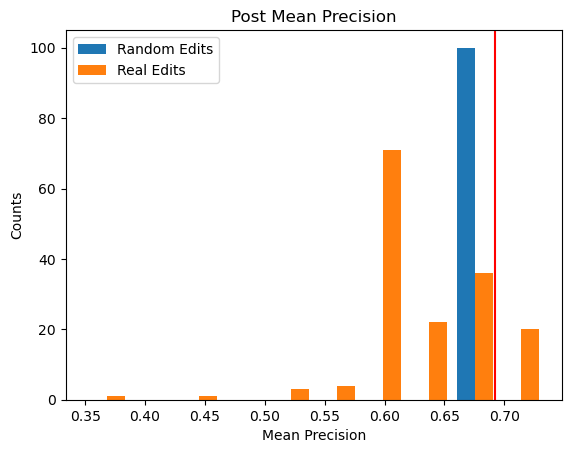

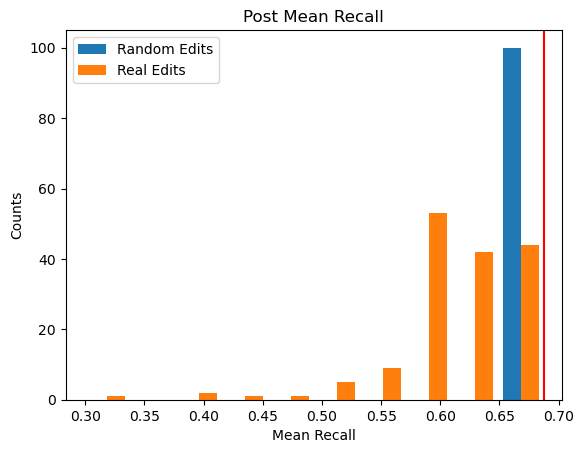

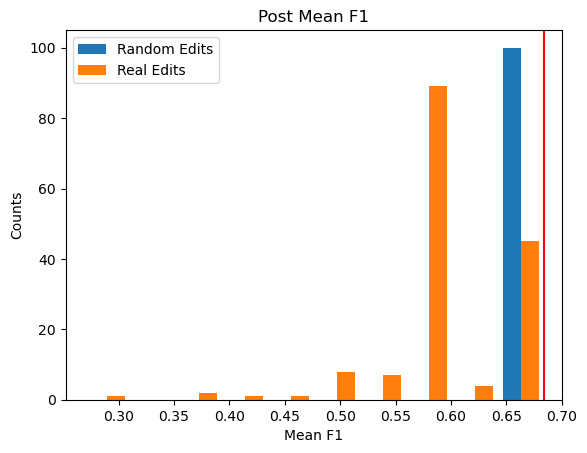

<Figure size 640x480 with 0 Axes>

In [55]:
metrics = [['{} Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1']]

summary_histograms(
    dfs=[random_df, edit_df],
    metrics=metrics,
    n_bins=10,
    labels=["Random Edits", "Real Edits"],
    save_dir=save_visualizations_dir)
    

#### Pretend there is a "target class" and analyze recall

In [56]:
# Assert target class has the highest change in recall for real edits
edit_post_per_class_recall = edit_df['Post Per-Class Recall'].to_numpy()
edit_post_per_class_recall = np.stack(edit_post_per_class_recall, axis=0)

edit_pre_per_class_recall = edit_df['Pre Per-Class Recall'].to_numpy()
edit_pre_per_class_recall = np.stack(edit_pre_per_class_recall, axis=0)

diff = edit_post_per_class_recall - edit_pre_per_class_recall
max_edit_diff_recall = np.amax(diff, axis=1)
max_diff_idx = np.argmax(diff, axis=1)
percent_target = np.count_nonzero(max_diff_idx == target_class_idx) / max_diff_idx.size
print("{:.2f}% of edits with target class having highest recall improvement are target class {}".format(
    100 * percent_target, 
    target_class_name))

86.71% of edits with target class having highest recall improvement are target class airplane


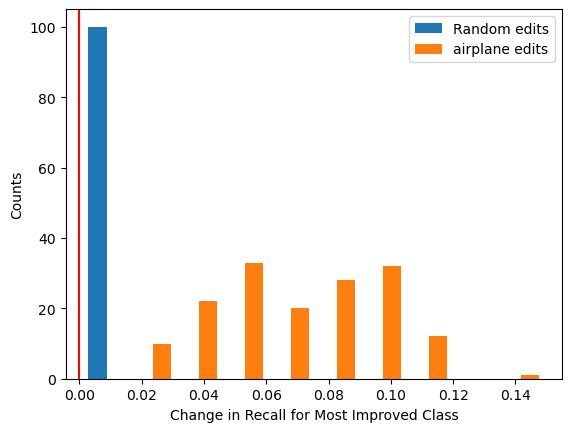

<Figure size 640x480 with 0 Axes>

In [57]:
# Get pseudo change in 'target' recall for random edits
post_per_class_recalls = random_df['Post Per-Class Recall'].to_numpy()
post_per_class_recalls = np.stack(post_per_class_recalls, axis=0)

pre_per_class_recalls = random_df['Pre Per-Class Recall'].to_numpy()
pre_per_class_recalls = np.stack(pre_per_class_recalls, axis=0)

differences = post_per_class_recalls - pre_per_class_recalls
max_diff = np.amax(differences, axis=1)
max_diff_idxs = np.argmax(differences, axis=1)

# Calculate change in target recall for real edits
delta_recall_real = edit_df['Post Target Recall'].to_numpy() - edit_df['Pre Target Recall'].to_numpy()
histogram(
    data=[max_diff, max_edit_diff_recall],
    n_bins=10,
    xlabel='Change in Recall for Most Improved Class',
    ylabel='Counts',
    labels=["Random edits", "{} edits".format(target_class_name)],
    marker=0.0,
    save_path=os.path.join(save_visualizations_dir, 'max_delta_recall.png'))
